In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [1]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/distan_lat42.22lon-8.63p2R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Visibility statistics


count    90008.000000
mean      8306.777209
std       3202.650054
min         48.000000
25%       8996.000000
50%       9994.000000
75%       9994.000000
max       9994.000000
Name: visibility_o, dtype: float64

*****************************
Climatology visibility <= 1000 meters


>1000m     91%
<=1000m     9%
Name: vis_l, dtype: object

*****************************


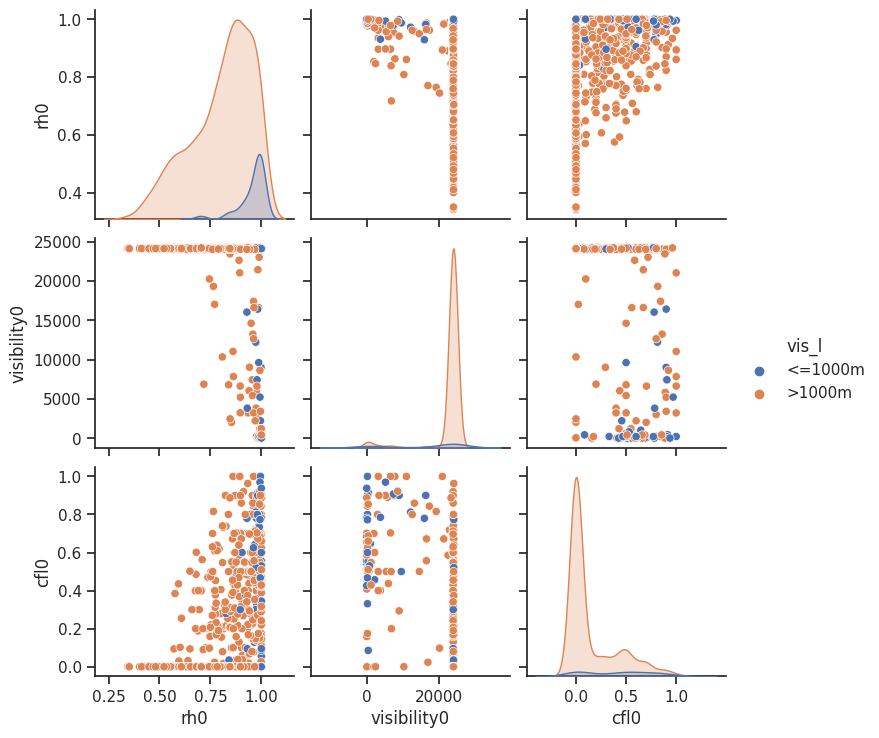

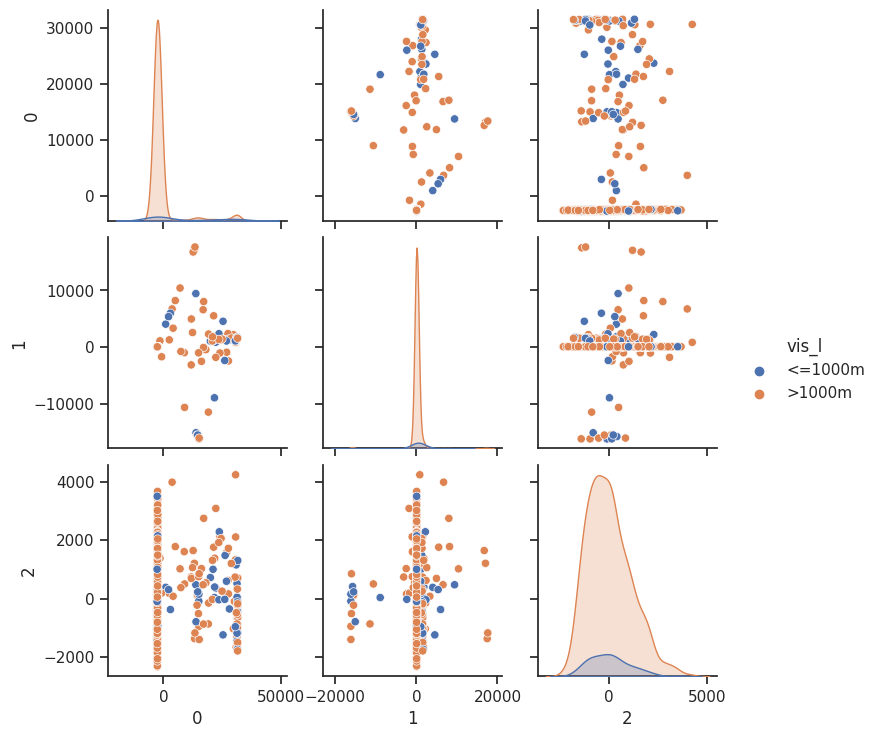

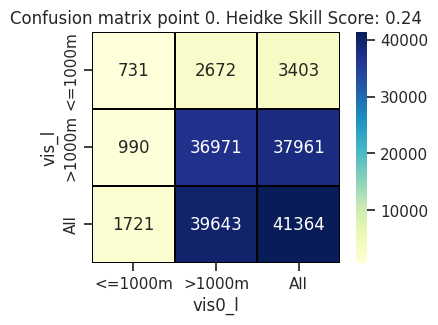

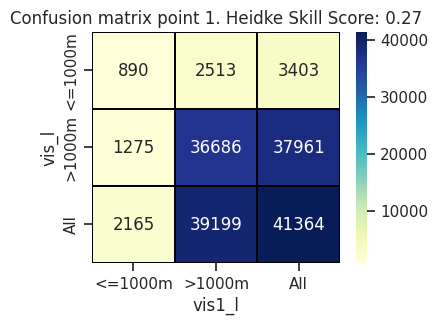

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 2784.9947469426693
Reject H0,There is an association between machine learning forecast and observed values


In [2]:
#@title Load station (visibility). Load meteorological model forecast D0. Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/LEVXY2018Y2022.csv",
                          usecols =["time","visibility_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Visibility statistics")
display(station["visibility_o"].describe())

#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,1000), (1000, 40000)])
labels = ['<=1000m', '>1000m']
station["vis_l"] = pd.cut(station["visibility_o"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

print("*****************************")
print("Climatology visibility <= 1000 meters")
display(station["vis_l"].value_counts(normalize=True).map(lambda n: '{:.0%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["visibility_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["vis_l","rh0","visibility0","cfl0"]].sample(1000)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="vis_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["vis_l"] = df_all.vis_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(1000), hue="vis_l");
plt.show()

#label meteorological model variables dir0 and dir1
df_all["vis0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all["vis1_l"] = pd.cut(df_all["visibility1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.vis_l, df_all.vis0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
cm1 = pd.crosstab(df_all.vis_l, df_all.vis1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


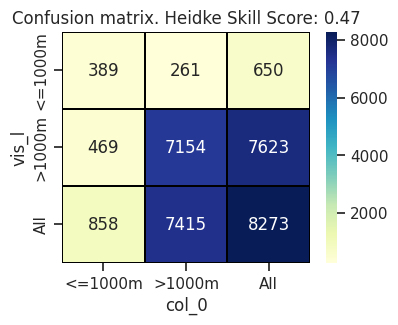

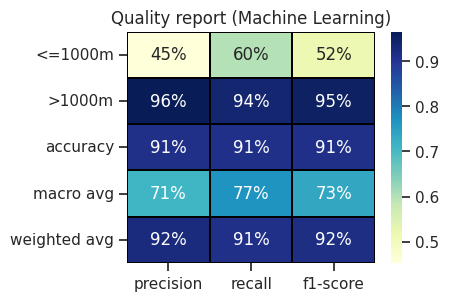

,feature,feature_per
52,dayofyear,6.2%
50,hour,3.9%
0,dir0,3.5%
2,snowlevel0,2.9%
25,dir1,2.8%
42,cfh1,2.6%
8,visibility0,2.5%
9,lhflx0,2.5%
5,mslp0,2.4%
24,T8500,2.4%



HSS stadistics
             HSS
count  10.000000
mean    0.470567
std     0.020763
min     0.422447
25%     0.464966
50%     0.474307
75%     0.484306
max     0.491760
Shapiro test normality
p value: 0.0990101620554924
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1851.822395466671
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 1.12 minutes


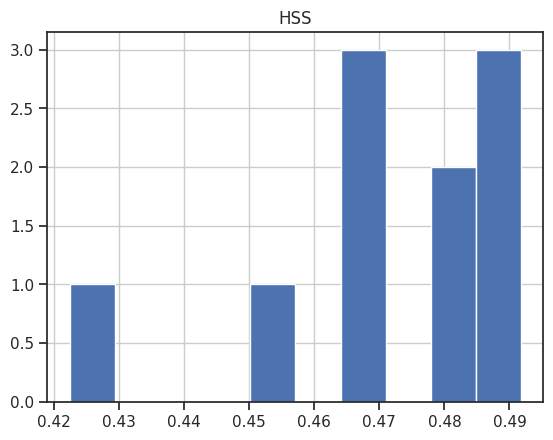

In [3]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                       "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [4]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/vis_LEVX_d0.al", 'wb'))

Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


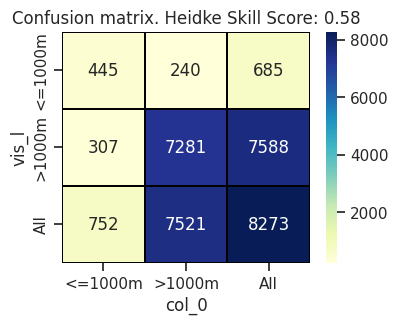

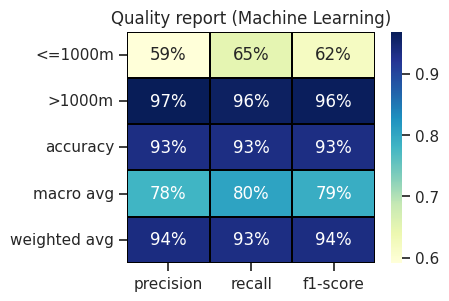

,feature,feature_per
7,rh0,6.6%
32,rh1,5.1%
43,cfl1,5.0%
50,hour,4.7%
18,cfl0,4.1%
33,visibility1,3.5%
20,cft0,2.9%
34,lhflx1,2.8%
8,visibility0,2.7%
45,cft1,2.7%



HSS stadistics
             HSS
count  10.000000
mean    0.579117
std     0.010301
min     0.558761
25%     0.574805
50%     0.579767
75%     0.583023
max     0.593682
Shapiro test normality
p value: 0.7033876180648804
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2814.091395935207
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.72 minutes


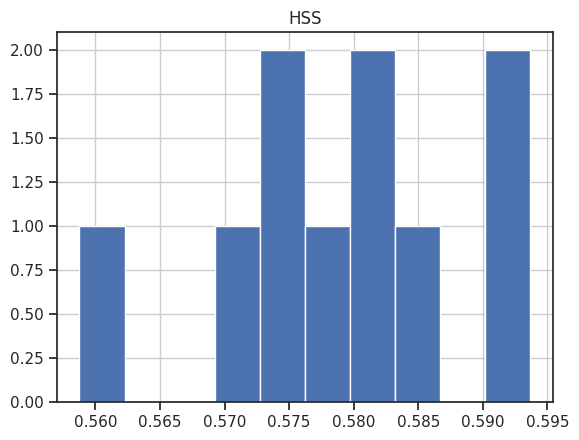

In [5]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                        "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")







In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/vis_LEVX_d0.al", 'wb'))

*****************************


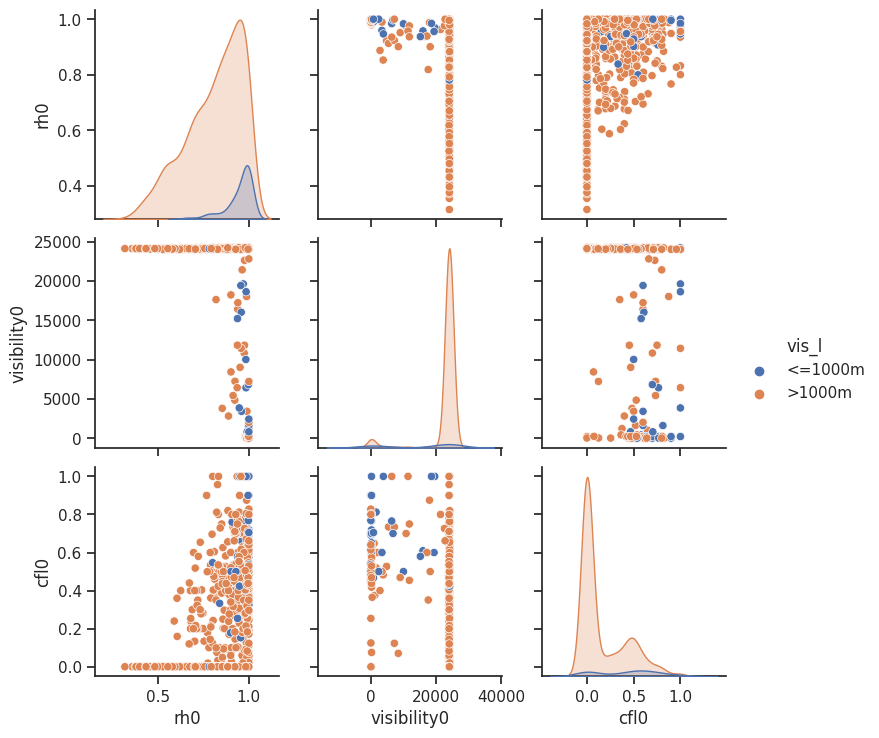

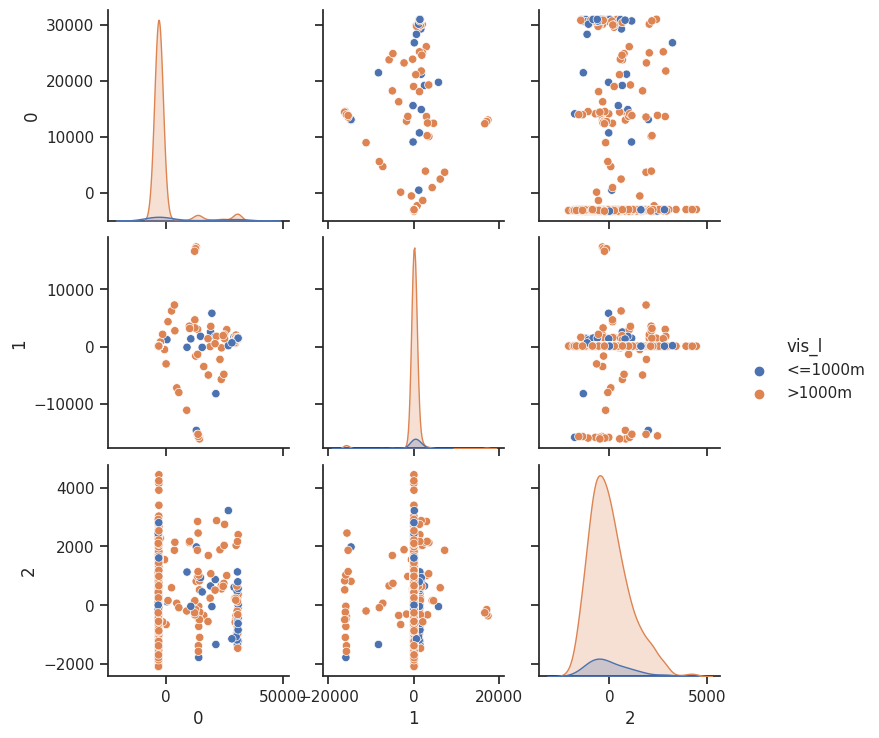

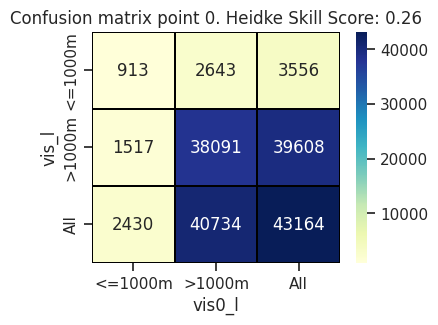

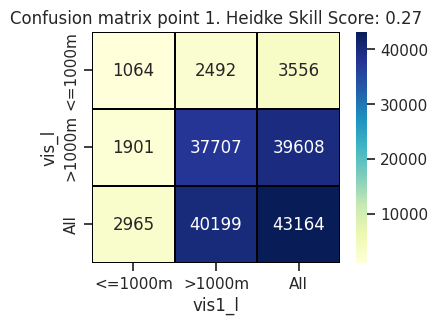

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 2926.799073013586
Reject H0,There is an association between machine learning forecast and observed values


In [6]:
#@title Load meteorological model forecast D1.Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["visibility_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["vis_l","rh0","visibility0","cfl0"]].sample(1000)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="vis_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["vis_l"] = df_all.vis_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(1000), hue="vis_l");
plt.show()

#label meteorological model variables dir0 and dir1
df_all["vis0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")
df_all["vis1_l"] = pd.cut(df_all["visibility1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("category")

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.vis_l, df_all.vis0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
cm1 = pd.crosstab(df_all.vis_l, df_all.vis1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()
plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


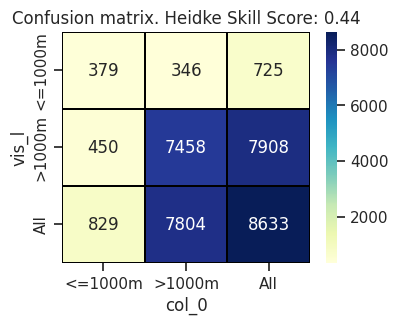

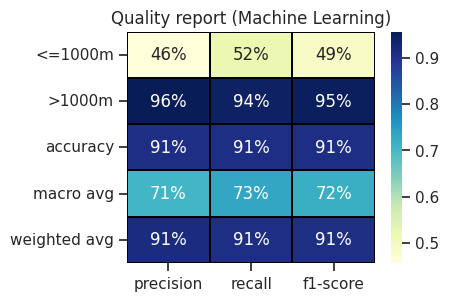

,feature,feature_per
52,dayofyear,7.0%
50,hour,4.2%
17,cfh0,3.2%
25,dir1,3.2%
49,T8501,3.0%
0,dir0,2.9%
5,mslp0,2.5%
30,mslp1,2.4%
8,visibility0,2.4%
21,HGT5000,2.4%



HSS stadistics
             HSS
count  10.000000
mean    0.442610
std     0.008000
min     0.425695
25%     0.438786
50%     0.444709
75%     0.446583
max     0.454239
Shapiro test normality
p value: 0.4549765884876251
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1654.9687372022722
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 1.12 minutes


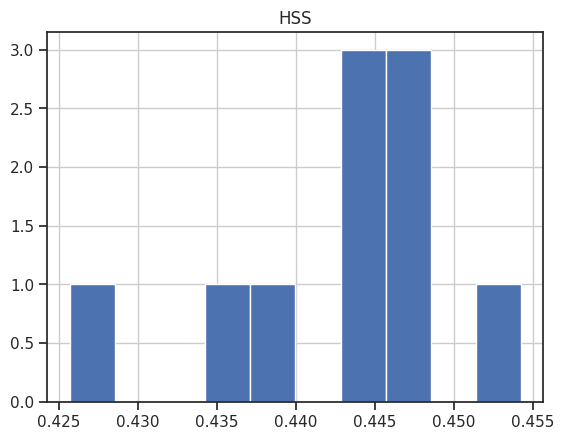

In [7]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score
start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                        "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [8]:
#@title Save last algorithm round 9

x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/vis_LEVX_d1.al", 'wb'))


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


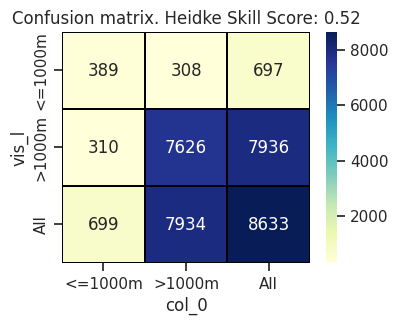

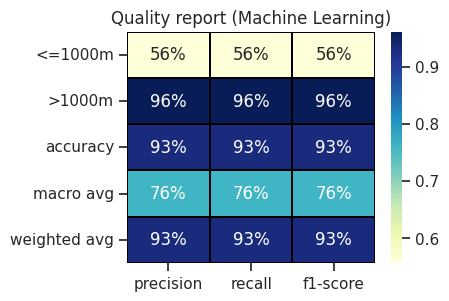

,feature,feature_per
32,rh1,5.4%
7,rh0,5.1%
18,cfl0,4.5%
50,hour,4.5%
33,visibility1,4.4%
43,cfl1,3.8%
8,visibility0,3.2%
9,lhflx0,3.1%
20,cft0,2.6%
45,cft1,2.4%



HSS stadistics
             HSS
count  10.000000
mean    0.551776
std     0.022480
min     0.518365
25%     0.537612
50%     0.552711
75%     0.559219
max     0.601519
Shapiro test normality
p value: 0.3788634240627289
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2312.7448737117434
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.29 minutes


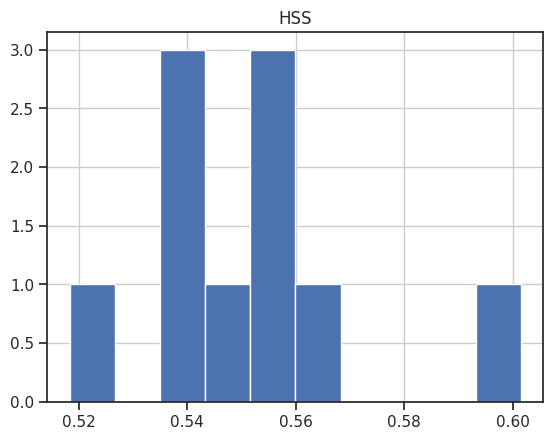

In [9]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.vis_l
X = df_all.iloc[:,1:].drop(columns=['vis0_l', 'vis1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
       return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                       "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/vis_LEVX_d1.al", 'wb'))